In [1]:
# Crypto heatmap

In [2]:
import requests 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('ggplot')
%matplotlib inline 

In [3]:
url = "https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=10&e=Coinbase"
f = requests.get(url)
ipdata = f.json()
pd.DataFrame(ipdata['Data']).head(5)

,close,high,low,open,time,volumefrom,volumeto
0,10365.93,10452.50,10157.00,10423.72,1568332800,6799.62,70031660.47
1,10360.25,10439.00,10223.36,10365.93,1568419200,4413.03,45673649.10
2,10304.46,10380.00,10263.39,10360.25,1568505600,2735.17,28202179.16
3,10262.54,10379.98,10068.42,10304.46,1568592000,7384.74,75476404.07
4,10185.39,10276.18,10135.44,10262.54,1568678400,5710.49,58364825.36


In [4]:
def get_data(date):
    """query API for 2000 days historical price data starting from "date"."""
    url = "https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=2000&toTs={}".format(date)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata 

In [5]:
def get_df(from_date, to_date):
    date = to_date
    holder = []
    # while earliest date returned is later than the earliest data requested, keep querying API # and adding results to list 
    while date > from_date:
        data = get_data(date)
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom']
        # join together all api queries from list 
        df = pd.concat(holder, axis=0)
        # remove data points from before from_date
        df = df[df['time']>from_date]
        # convert to timestamp 
        df['time'] = pd.to_datetime(df['time'], unit='s')
        # make datafrom index the time
        df.set_index('time', inplace=True)
        # sort in time order
        df.sort_index(ascending=False, inplace=True)
        return df

In [6]:
df = get_df(1567296000, 1569260663)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


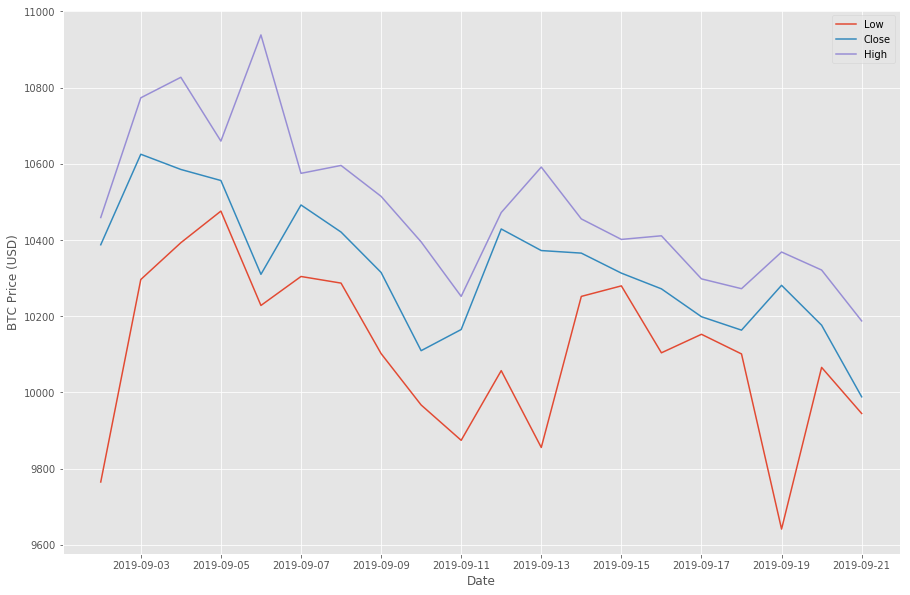

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(df[['low', 'close', 'high']])
ax.set_ylabel('BTC Price (USD)')
ax.set_xlabel('Date')
ax.legend(['Low', 'Close', 'High']);

In [8]:
def get_data_spec(coin, date, time_period):
    """query api for historical data starting from "date"."""
    url = "https://min-api.cryptocompare.com/data/{}?fsym={}&tsym=USD&Limit=2000&toTs={}".format(time_period, coin, date)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

In [9]:
def get_df_spec(time_period, coin, from_date, to_date):
    """ get historical price data between dates. If further apart query multiple times."""
    date = to_date
    holder = []
    while date > from_date:
        data = get_data_spec(coin, date, time_period) 
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom'] 
    df = pd.concat(holder, axis = 0)
    df = df[df['time']>from_date]
    df['time'] = pd.to_datetime(df['time'], unit='s') 
    df.set_index('time', inplace=True)
    df.sort_index(ascending=False, inplace=True) 
    df.rename(columns={'close':coin}, inplace=True)
    return df[coin]

In [10]:
coins = ['BTC', 'ETH', 'LTC', 'EOS', 'XLM', 'XMR','USDT']

In [11]:
holder = []
from_date = 1567296000 # 09-01-2019
to_date = 1569260663   # Today
time_period = 'histoday'
for coin in coins:
    holder.append(get_df_spec(time_period, coin, from_date, to_date))
df = pd.concat(holder, axis = 1)

In [12]:
# convert each column of df to be rate of return instead of price
df = df.divide(df.shift())-1
df_norm_col=(df-df.mean())/df.std()

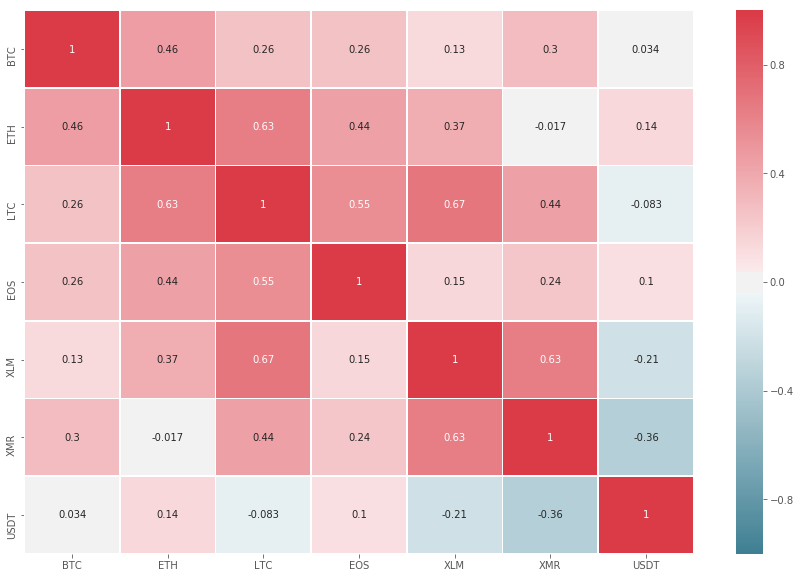

In [13]:
import seaborn as sns 
plt.figure(figsize=(15,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(df.corr(), vmin=-1, annot=True, annot_kws={"size": 10}, linewidth=0.5, cmap=cmap)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 1080x720 with 0 Axes>

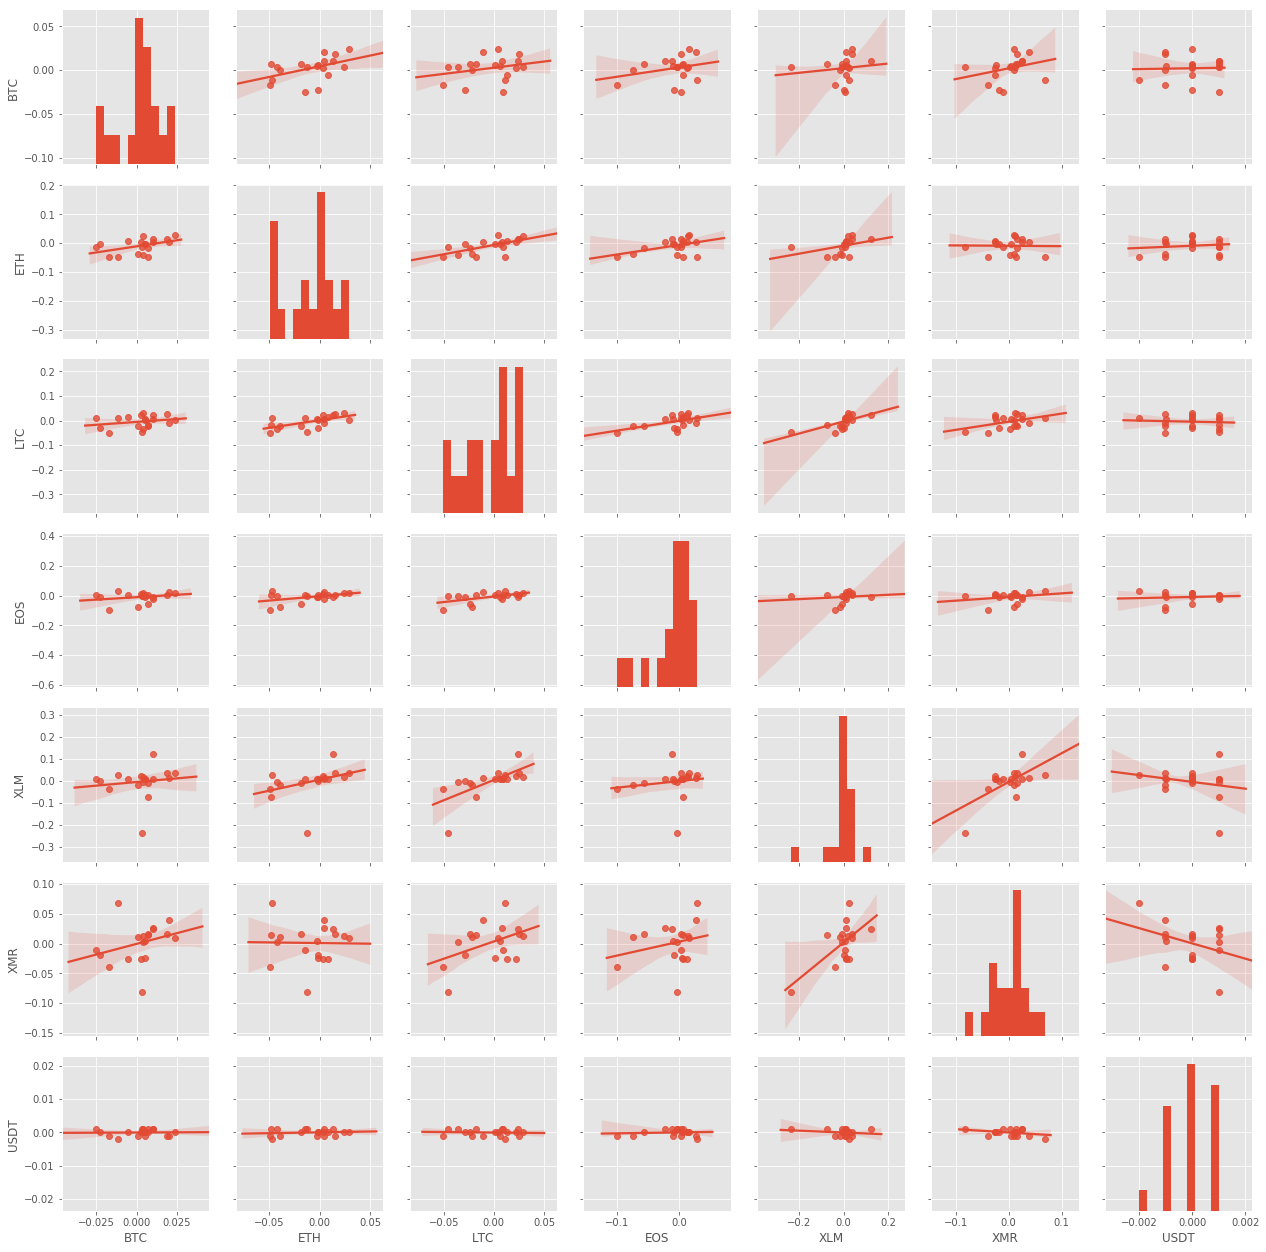

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,10))

sns.pairplot(df, kind='reg', palette='Set2')
plt.show()